<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesora: Maria Paz Raveau</em><br>
    <em>Asignatura: Procesamiento de Lenguaje Natural</em><br>

</div>

# **Tarea 1**

*Fecha de Entrega: Domingo 20, Julio 2025.*

**Nombre Estudiante**: Victor Saldivia Vera

### **01. Intrucciones y Enunciado**

Suponga que ud. es contactado por alguna agencia gubernamental que quiere saber qué dijeron los participantes de los cabildos de 2016. Ud. debe entonces, basándose en los textos de fundamento, responder a este requerimiento.  Use para ello la base de datos que vimos en clases, de los cabildos provinciales. 

- Escoja alguna de los conceptos que vienen en la base de datos (evite las que no tengan muchas entradas). Hemos visto cómo generar WordClouds con tokens y con bigramas. *¿Es posible valerse de las etiquetas gramaticales para mejorar el resultado?* 
- Pruebe haciendo un WordCloud con tokens/sustantivos,  y otro con  bigramas/sustantivo-adjetivo. Recuerde pre-procesar correctamente.
- Con estos mismo bigramas/sustantivo-adjetivo, haga una red de bigramas.
- Ayúdese con frases de ejemplo, y de los WordClouds, para escribir una descripción del concepto.


### **02. Descripción de la Data**

Carga y primeras exploraciones del DataFrame original.  
- Columnas disponibles: 12  
- Tamaño del dataset: 30414 registros  
- Conteo de nulos en las columnas de texto: 0


**Información Adicional:** Para ver en detalle la implementación completa de la tarea visitar el repositorio en Github.


**Repositorio GitHub de la Tarea**
- Tarea 1: https://github.com/Vikktor93/tarea1-NLP

In [1]:
import pandas as pd
df = pd.read_excel('data/raw/resultadocabildoprovincial.xlsx')
print(f'Dimensión: {df.shape}'), 
print(f'Nombre de Columnas: {df.columns}')

Dimensión: (30414, 12)
Nombre de Columnas: Index(['region_nombre', 'provincia_nombre', 'comuna_nombre', 'cabildo_id',
       'cabildo_nombre', 'cabildo_direccion', 'num_mesa', 'pregunta_glosa',
       'concepto_nombre', 'concepto_otro', 'tipo-eleccion', 'fundamento'],
      dtype='object')


### **03. Librerías a Utilizar**
Importación de librerías necesarias:

- **Pandas**, **NumPy** y expresiones regulares para limpieza  
- **Stanza** para NLP (tokenización, POS, lematización)  
- **NLTK** para stopwords y collocations  
- **WordCloud**, **NetworkX** y **Matplotlib** para visualización  
- **tqdm** para barras de progreso.

In [3]:
import numpy as np
import re
import os
import unicodedata
from collections import Counter

# Librerías de Procesamiento de Texto
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
import stanza

# Visualización
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from wordcloud import WordCloud
import networkx as nx

# La librería de warnings se utiliza para manejar las advertencias
import warnings
warnings.filterwarnings('ignore')

# Paquete muestra Barra de Progreso
from tqdm import tqdm
tqdm.pandas()

Se estableció `KMP_DUPLICATE_LIB_OK=TRUE` para evitar conflicto de múltiples runtimes OpenMP en Windows. Es un workaround temporal *(solución temporal)*.

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
# Descargas (Nota: Ejecutar una sola vez en entorno local)
# nltk.download('punkt')
# nltk.download('stopwords')
# stanza.download('es')

#### Configuración de Stanza para el NLP

In [5]:
nlp = stanza.Pipeline('es', processors='tokenize,pos,lemma', use_gpu=False)  # Cambiar a True si hay GPU


2025-07-20 20:22:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-07-20 20:22:43 INFO: Downloaded file to C:\Users\Victo\stanza_resources\resources.json
2025-07-20 20:22:43 WARNING: Language es package default expects mwt, which has been added
2025-07-20 20:22:44 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2025-07-20 20:22:44 INFO: Using device: cpu
2025-07-20 20:22:44 INFO: Loading: tokenize
2025-07-20 20:22:46 INFO: Loading: mwt
2025-07-20 20:22:46 INFO: Loading: pos
2025-07-20 20:22:47 INFO: Loading: lemma
2025-07-20 20:22:49 INFO: Done loading processors!


### **04. Carga y Exploración Inicial**


In [6]:
df.head()

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento
0,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Autonomía/libertad,NaN,A,sin fundamento
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Sin fundamento
2,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Descentralización,NaN,A,La descentralizacion de ser autonoma por ser z...
3,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Equidad de género,NaN,A,Sin fundamento
4,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Respeto/conservación de la naturaleza o medio ...,NaN,A,Sin fundamento


#### Conteo de nulos en columnas de texto


In [10]:
texto_col = "fundamento"
print(df[texto_col].isna().sum())

0


#### Estadísticas Descriptivas sobre el texto


In [11]:
df['len_chars'] = df[texto_col].str.len() # columna de longitud de caracteres
df['len_tokens_raw'] = df[texto_col].str.split().str.len() # columna de tokens sin procesar
df[['len_chars','len_tokens_raw']].describe()

,len_chars,len_tokens_raw
count,19326.000000,19326.000000
mean,100.842337,15.763014
std,68.723444,10.954642
min,1.000000,1.000000
25%,50.000000,8.000000
50%,84.000000,13.000000
75%,134.000000,21.000000
max,300.000000,61.000000


#### Eliminación de nulos y duplicados


In [13]:
before = len(df)
df = df.dropna(subset=[texto_col])
df = df.drop_duplicates(subset=[texto_col])
print(f"Filas eliminadas: {before - len(df)}")

Filas eliminadas: 0


### **05. Selección de Concepto**
Se exploran las frecuencias de `concepto_nombre` y se elige el concepto.

- Se elige el concepto `Democracia` ya que tienen una alta frecuencia (Top 3) 
- Se construye yb sub conjunto `subset` filtrado por el concepto elegido

In [14]:
# Distribución de frecuencias para elegir uno con suficientes observaciones
concepto_col = "concepto_nombre" 
concept_counts = df[concepto_col].value_counts()
concept_counts.head(20)

concepto_nombre
Otro                                                      3976
Igualdad                                                   519
Democracia                                                 507
Descentralización                                          503
Justicia                                                   492
Respeto/conservación de la naturaleza o medio ambiente     484
A la vida                                                  440
A la salud                                                 437
A la educación                                             428
Respeto                                                    385
Fuerzas Armadas                                            381
Bien Común/comunidad                                       381
Congreso o parlamento (estructura y funciones)             373
A la vivienda digna                                        365
Plebiscitos, referendos y consultas                        361
Respeto por la constitución            

#### Selección de Concepto

In [15]:
concepto_elegido = "Democracia" 

#### Creación del Subconjunto filtrado
Se elige el concepto 'Democracia' el cual tiene una frecuencia de (507 ocurrencias) para garantizar masa textual suficiente y diversidad léxica. Se descartaron conceptos con baja frecuencia para evitar resultados inestables en nubes de palabras y bigramas.”



In [16]:
subset = df[df[concepto_col] == concepto_elegido].copy()
print("Filas del concepto:", len(subset))

Filas del concepto: 507


In [18]:
subset.head(10)

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento,len_chars,len_tokens_raw
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Sin fundamento,14,2
142,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Que el ciudadano pueda participar en la toma d...,141,22
169,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",6,¿Cuáles son los valores y principios más impor...,Democracia,NaN,P,Las condiciones actuales no constituyen democr...,118,17
283,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",9,¿Cuáles son los valores y principios más impor...,Democracia,NaN,P,por la estructura establecida en el dialogo an...,52,8
316,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",10,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,debemos pasar de una democracia representativa...,66,9
363,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",11,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,por eso estamos aqui,20,4
491,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",14,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Se garantice una democracia vinculante que se ...,89,14
526,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",15,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,la base y el principio de todos,31,7
746,Arica y Parinacota,Parinacota,Putre,121,Liceo Granaderos de Putre,"Teniente del Campo 242, Putre",2,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Mejorar en todos los aspectos los sistemas de...,258,41
945,Tarapacá,Iquique,Alto Hospicio,107,San Antonio de Matilla,"Los Kiwis 3443, Alto Hospicio",2,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Elemento fundamental en la nueva constitución ...,54,8


#### Se Guarda subset limpio en formato CSV 

In [19]:
subset.to_csv(
    'data/processed/subset_limpio.csv',
    index=False,
    encoding='utf-8-sig'
)
print(f"Subset limpio guardado: {len(subset)} filas → data/processed/subset_limpio.csv")

Subset limpio guardado: 507 filas → data/processed/subset_limpio.csv


### **06. Pre-Procesamiento de Texto**

**Limpieza de texto**  
1. Remoción de Ruido Semántico (ejemplo: “sin fundamento”)  
2. Normalización a minúsculas
3. Eliminación de caracteres especiales y tildes
4. Eliminación de espacios extras

In [20]:
PLACEHOLDER_PATTERNS = {
    'sin fundamento','sin  fundamento','sinfundamento','sf','nuevo concepto'
}

def is_placeholder(text):
    if not isinstance(text, str):
        return True
    t = text.strip().lower()
    t = re.sub(r'\s+', ' ', t)
    return t in PLACEHOLDER_PATTERNS

before_ph = len(df)
df = df[~df[texto_col].apply(is_placeholder)]
print(f"{before_ph - len(df)} filas eliminadas por ser placeholders")

7 filas eliminadas por ser placeholders


#### Normalización de Texto

In [21]:
def normalize_text(text: str) -> str:
    text = str(text).lower() #
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8','ignore')  # eliminar tildes
    text = re.sub(r'[^a-z0-9\\s]', ' ', text) # eliminar caracteres especiales
    text = re.sub(r'\\s+', ' ', text).strip() # eliminar espacios extra
    return text

subset['texto_norm'] = subset[texto_col].apply(normalize_text)

In [22]:
subset

,region_nombre,provincia_nombre,comuna_nombre,cabildo_id,cabildo_nombre,cabildo_direccion,num_mesa,pregunta_glosa,concepto_nombre,concepto_otro,tipo-eleccion,fundamento,len_chars,len_tokens_raw,texto_norm
1,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",1,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Sin fundamento,14,2,sin fundamento
142,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",5,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Que el ciudadano pueda participar en la toma d...,141,22,que el ciudadano pueda participar en la toma d...
169,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",6,¿Cuáles son los valores y principios más impor...,Democracia,NaN,P,Las condiciones actuales no constituyen democr...,118,17,las condiciones actuales no constituyen democr...
283,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",9,¿Cuáles son los valores y principios más impor...,Democracia,NaN,P,por la estructura establecida en el dialogo an...,52,8,por la estructura establecida en el dialogo an...
316,Arica y Parinacota,Arica,Arica,81,Colegio San Marcos,"Santa María 2140, Arica",10,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,debemos pasar de una democracia representativa...,66,9,debemos pasar de una democracia representativa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30184,Magallanes y de la Antártica Chilena,Última Esperanza,Natales,144,Liceo Bernardo O'Higgins,"Eleuterio Ramirez 748, Natales",2,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Incorporarle nuevos elementos de acuerdo a los...,105,13,incorporarle nuevos elementos de acuerdo a los...
30212,Magallanes y de la Antártica Chilena,Última Esperanza,Natales,144,Liceo Bernardo O'Higgins,"Eleuterio Ramirez 748, Natales",3,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,La democracia debe ser la base de la sociedad ...,299,46,la democracia debe ser la base de la sociedad ...
30251,Magallanes y de la Antártica Chilena,Última Esperanza,Natales,144,Liceo Bernardo O'Higgins,"Eleuterio Ramirez 748, Natales",4,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,"Descentralización, con justicia e igualdad, co...",106,15,descentralizacion con justicia e igualdad co...
30290,Magallanes y de la Antártica Chilena,Última Esperanza,Natales,144,Liceo Bernardo O'Higgins,"Eleuterio Ramirez 748, Natales",6,¿Cuáles son los valores y principios más impor...,Democracia,NaN,A,Se relaciona con el concepto igualitario,40,6,se relaciona con el concepto igualitario


#### Tokenización + POS + Lematización
**Procesamiento con Stanza**  
- Se aplica el pipeline neuronal (`tokenize,pos,lemma`)
- Resultado: lista de tuplas `(token_original, lema, upos)` por documento

In [23]:
def stanza_process(doc_str: str):
    doc = nlp(doc_str)
    rows = []  # (token, lemma, upos)
    for sent in doc.sentences:
        for w in sent.words:
            rows.append((w.text, w.lemma.lower(), w.upos))
    return rows

subset['doc'] = subset['texto_norm'].progress_apply(stanza_process)

100%|██████████| 507/507 [01:19<00:00,  6.34it/s]


#### Visualización de tokens crudos (antes de filtrar stopwords) del subconjunto
- Generar y revisar top 30 de tokens lematizados antes de aplicar stopwords de dominio  

In [24]:
subset['tokens_crudos'] = subset['doc'].apply(lambda toks: [lemma for _, lemma, pos in toks])

freq_crudas = Counter([w for fila in subset['tokens_crudos'] for w in fila])
top30 = freq_crudas.most_common(30)
top30

[('el', 1071),
 ('de', 600),
 ('y', 399),
 ('que', 353),
 ('ser', 328),
 ('democracia', 308),
 ('él', 278),
 ('deber', 232),
 ('uno', 225),
 ('en', 217),
 ('a', 193),
 ('participativo', 181),
 ('participación', 157),
 ('como', 116),
 ('no', 113),
 ('para', 101),
 ('con', 99),
 ('ciudadano', 92),
 ('todo', 90),
 ('representativo', 82),
 ('por', 81),
 ('valor', 77),
 ('vinculante', 72),
 ('pueblo', 65),
 ('fundamental', 60),
 ('estar', 60),
 ('poder', 56),
 ('acuerdo', 55),
 ('derecho', 53),
 ('tener', 52)]

In [25]:
subset['doc']

1        [(sin, sin, ADP), (fundamento, fundamento, NOUN)]
142      [(que, que, SCONJ), (el, el, DET), (ciudadano,...
169      [(las, el, DET), (condiciones, condición, NOUN...
283      [(por, por, ADP), (la, el, DET), (estructura, ...
316      [(debemos, deber, AUX), (pasar, pasar, VERB), ...
                               ...                        
30184    [(incorporar, incorporar, VERB), (le, él, PRON...
30212    [(la, el, DET), (democracia, democracia, NOUN)...
30251    [(descentralizacion, descentralización, NOUN),...
30290    [(se, él, PRON), (relaciona, relacionar, VERB)...
30372    [(un, uno, DET), (valor, valor, NOUN), (necesa...
Name: doc, Length: 507, dtype: object

#### Stopwords
**Documentación de Stopwords**  
- Documentar la lista de Stopwords en archivo `stopwords_dominio.txt`.

In [26]:
spanish_sw = set(stopwords.words('spanish'))
spanish_sw

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

#### Guardando los stopwords en un archivo de texto


In [27]:
with open('output/tables/stopwords_español.txt', 'w', encoding='utf-8') as f:
    for w in sorted(spanish_sw):
        f.write(w + '\n')
print(f"Stopwords guardadas en el archivo stopwords_español.txt ({len(spanish_sw)} palabras)")


Stopwords guardadas en el archivo stopwords_español.txt (313 palabras)


### **07. Extracción de Sustantivos, Adjetivos y Bigramas**
**Filtrado POS (Part‑Of‑Speech)**  
- Sustantivos y nombres propios (`NOUN`, `PROPN`)  
- Adjetivos (`ADJ`)  
- Bigramas sustantivo–adjetivo contiguos  
- Eliminación de tokens con frecuencia <2 y stopwords de dominio

#### Filtrar Sustantivos

In [28]:
subset['nouns'] = subset['doc'].apply(
    lambda toks: [lemma for _, lemma, pos in toks
                  if pos in {"NOUN","PROPN"} and lemma not in spanish_sw and len(lemma) > 2]
)

In [29]:
subset['nouns']

1                                             [fundamento]
142      [ciudadano, toma, decisión, igualdad, aceptaci...
169      [condición, democracia, obstante, valor, const...
283                                  [estructura, dialogo]
316                                           [democracia]
                               ...                        
30184                          [elemento, acuerdo, tiempo]
30212    [democracia, base, sociedad, modalidad, gobier...
30251    [descentralización, justicia, igualdad, opinió...
30290                                           [concepto]
30372    [valor, sistema, ciudadanía, aumento, priorida...
Name: nouns, Length: 507, dtype: object

#### Filtrar Adjetivos

In [30]:
subset['adjs'] = subset['doc'].apply(
    lambda toks: [lemma for _, lemma, pos in toks
                  if pos == 'ADJ' and len(lemma) > 2]
)

In [31]:
subset['adjs']

1                                                       []
142                                                     []
169                           [actual, fundamental, nuevo]
283                                [establecido, anterior]
316                        [representativo, participativo]
                               ...                        
30184    [nuevo, ademocracia, sustentable, sostenible, ...
30212    [chileno, democratico, fundamental, directo, r...
30251                                                   []
30290                                        [igualitario]
30372                     [necesario, politico, controlar]
Name: adjs, Length: 507, dtype: object

#### Bigramas Sustantivo–Adjetivo contiguos


In [32]:
def noun_adj_bigrams(tok_rows):
    bigs = []
    for i in range(len(tok_rows)-1):
        (_, lemma1, pos1) = tok_rows[i]
        (_, lemma2, pos2) = tok_rows[i+1]
        if pos1 in {'NOUN','PROPN'} and pos2 == 'ADJ':
            if lemma1 not in spanish_sw and lemma2 not in spanish_sw:
                bigs.append(f'{lemma1}_{lemma2}')
    return bigs

subset['bigrams_noun_adj'] = subset['doc'].apply(noun_adj_bigrams)

### **08. Conteos Globales**

**Conteos finales**  
- `all_nouns`: Contador de sustantivos  
- `all_bigrams`: Contador de bigramas N‑A  
- `adj_counts`: Contador de adjetivos  

In [33]:
all_nouns = Counter([w for fila in subset['nouns'] for w in fila])
all_bigrams = Counter([b for fila in subset['bigrams_noun_adj'] for b in fila])
adj_counts = Counter([w for fila in subset['adjs'] for w in fila])
print('Unigramas distintos:', len(all_nouns))
print('Bigramas N-A distintos:', len(all_bigrams))
print('Adjetivos distintos:', len(adj_counts))

Unigramas distintos: 482
Bigramas N-A distintos: 397
Adjetivos distintos: 333


#### Remover claves vacías o sospechosas
Se crea la función `clean_key(k)` para verificar que una palabra no esté vacía, y sea de tipo string. También verifica que no contenga espacios en blancos el string. Se crea un diccionario llamado `filtered_items`, donde se agregan las palabras que pasan el filtro de la función `clean_key(k)` y que aparecerán al menos dos veces en el conteo global de sustantivos.

In [34]:
def clean_key(k):
    return bool(k) and isinstance(k, str) and not k.isspace()

filtered_items = {k:int(v) for k,v in all_nouns.items() if clean_key(k) and v>=2}

print("Vocabulario filtrado:", len(filtered_items), "Total frecuencia:", sum(filtered_items.values()))

Vocabulario filtrado: 213 Total frecuencia: 2339


### **09. Visualizaciones**

#### WordCloud Sustantivos - Concepto Elegido
- Se muestran términos con frecuencia ≥ 2  
- Parámetros ajustables: tamaño, max_words, etc  
- Interpretación: el nivel del tamaño indican importancia léxica del concepto

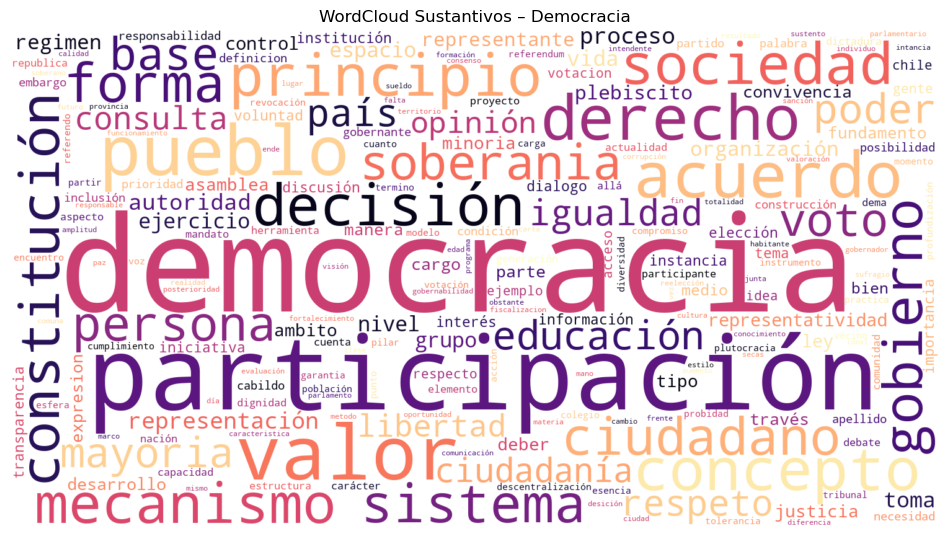

In [35]:
freq_unigrams = {w:c for w,c in all_nouns.items() if c>=2}
wc = WordCloud(width=1500, height=800, background_color='white', colormap="magma",  max_words=1000, collocations=False)
wc.generate_from_frequencies(freq_unigrams)
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f'WordCloud Sustantivos – {concepto_elegido}')
plt.savefig('output/figures/wordcloud_sustantivos.png', dpi=300)
plt.show()

#### WordCloud Bigramas (Sustantivo-Adjetivo)
- Se reemplaza el guión bajo con espacio para mejor legibilidad del WordCloud
- Mostrar bigramas con frecuencia ≥ 2 
- Parámetros similares al WordCloud de sustantivos

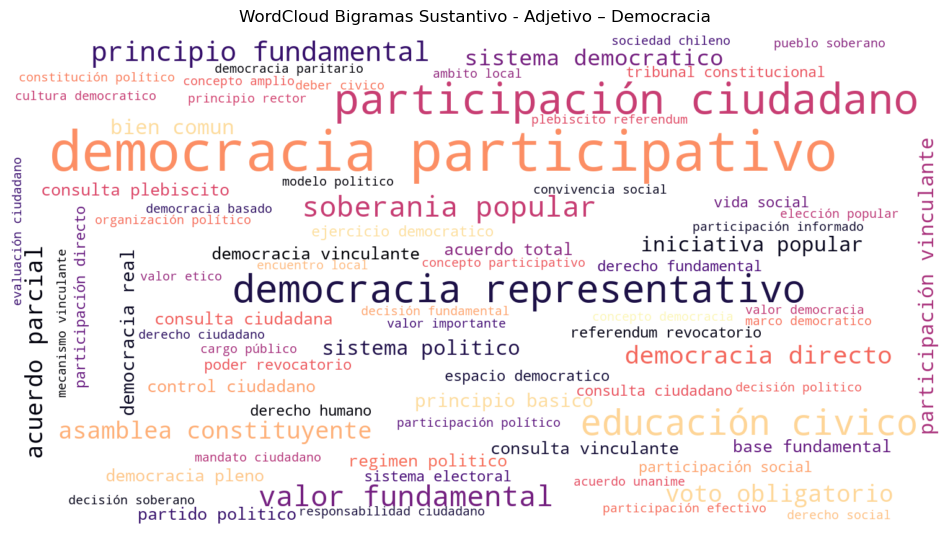

In [36]:
freq_bigrams = {b:c for b,c in all_bigrams.items() if c>=2}
freq_bigrams_space = {b.replace('_', ' '): c for b, c in freq_bigrams.items()} # Se crea un nuevo diccionario reemplazando '_' por ' '

wc2 = WordCloud(
    width=1500,
    height=800,
    background_color='white',
    colormap="magma",
    max_words=400,
    collocations=False
).generate_from_frequencies(freq_bigrams_space)

plt.figure(figsize=(12,8))
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title(f'WordCloud Bigramas Sustantivo - Adjetivo – {concepto_elegido}')
plt.savefig('output/figures/wordcloud_bigramas.png', dpi=300)
plt.show()

#### Histograma de Adjetivos

**Frecuencia de adjetivos**  
- Gráfico de barras horizontales de los 20 adjetivos más comunes  

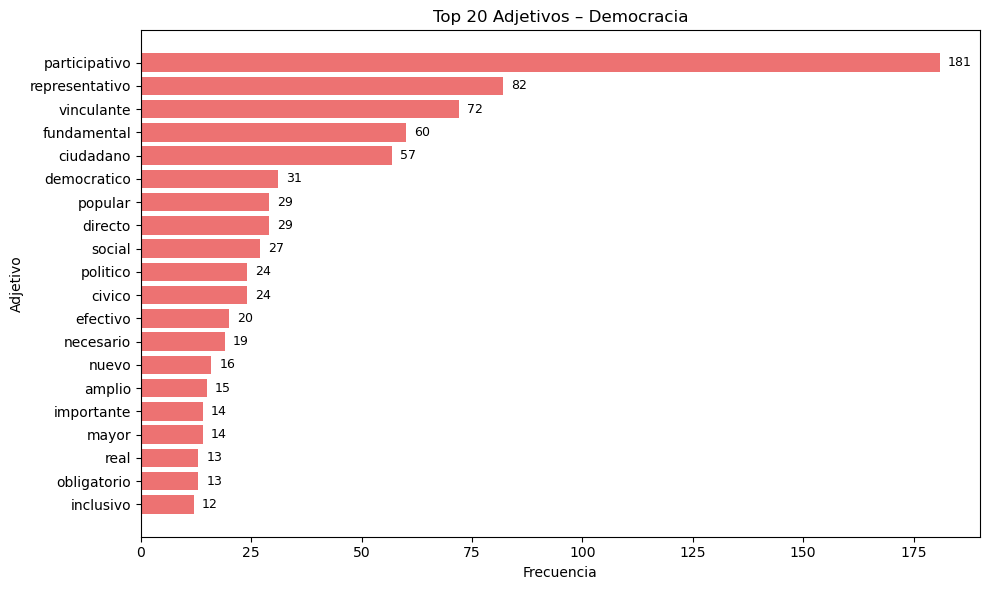

In [37]:
# Nuevo dataFrame de adjetivos
adj_df = pd.DataFrame(adj_counts.most_common(20), columns=['adjetivo','frecuencia'])

plt.figure(figsize=(10,6))
bars = plt.barh(adj_df['adjetivo'], adj_df['frecuencia'], color="#ED7272")

# Etiquetas de datos
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(adj_df['frecuencia']) * 0.01, 
        bar.get_y() + bar.get_height()/2,
        f'{int(width)}',
        va='center',
        fontsize=9
    )

plt.xlabel('Frecuencia')
plt.ylabel('Adjetivo')
plt.title(f'Top 20 Adjetivos – {concepto_elegido}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('output/figures/histograma_adjetivos.png', dpi=300)
plt.show()

#### Se almacena los Top 20 Adjetivos en un CSV

In [38]:
adj_df.to_csv('output/tables/top20_adjetivos.csv', index=False)

#### Red de Bigramas Sustantivo-Adjetivo
**Grafo**  
- Nodos: sustantivos (rojo pastel) y adjetivos (naranjo)  
- Aristas: relación sustantivo–adjetivo con peso=frecuencia  

Nodos: 82 | Aristas: 76


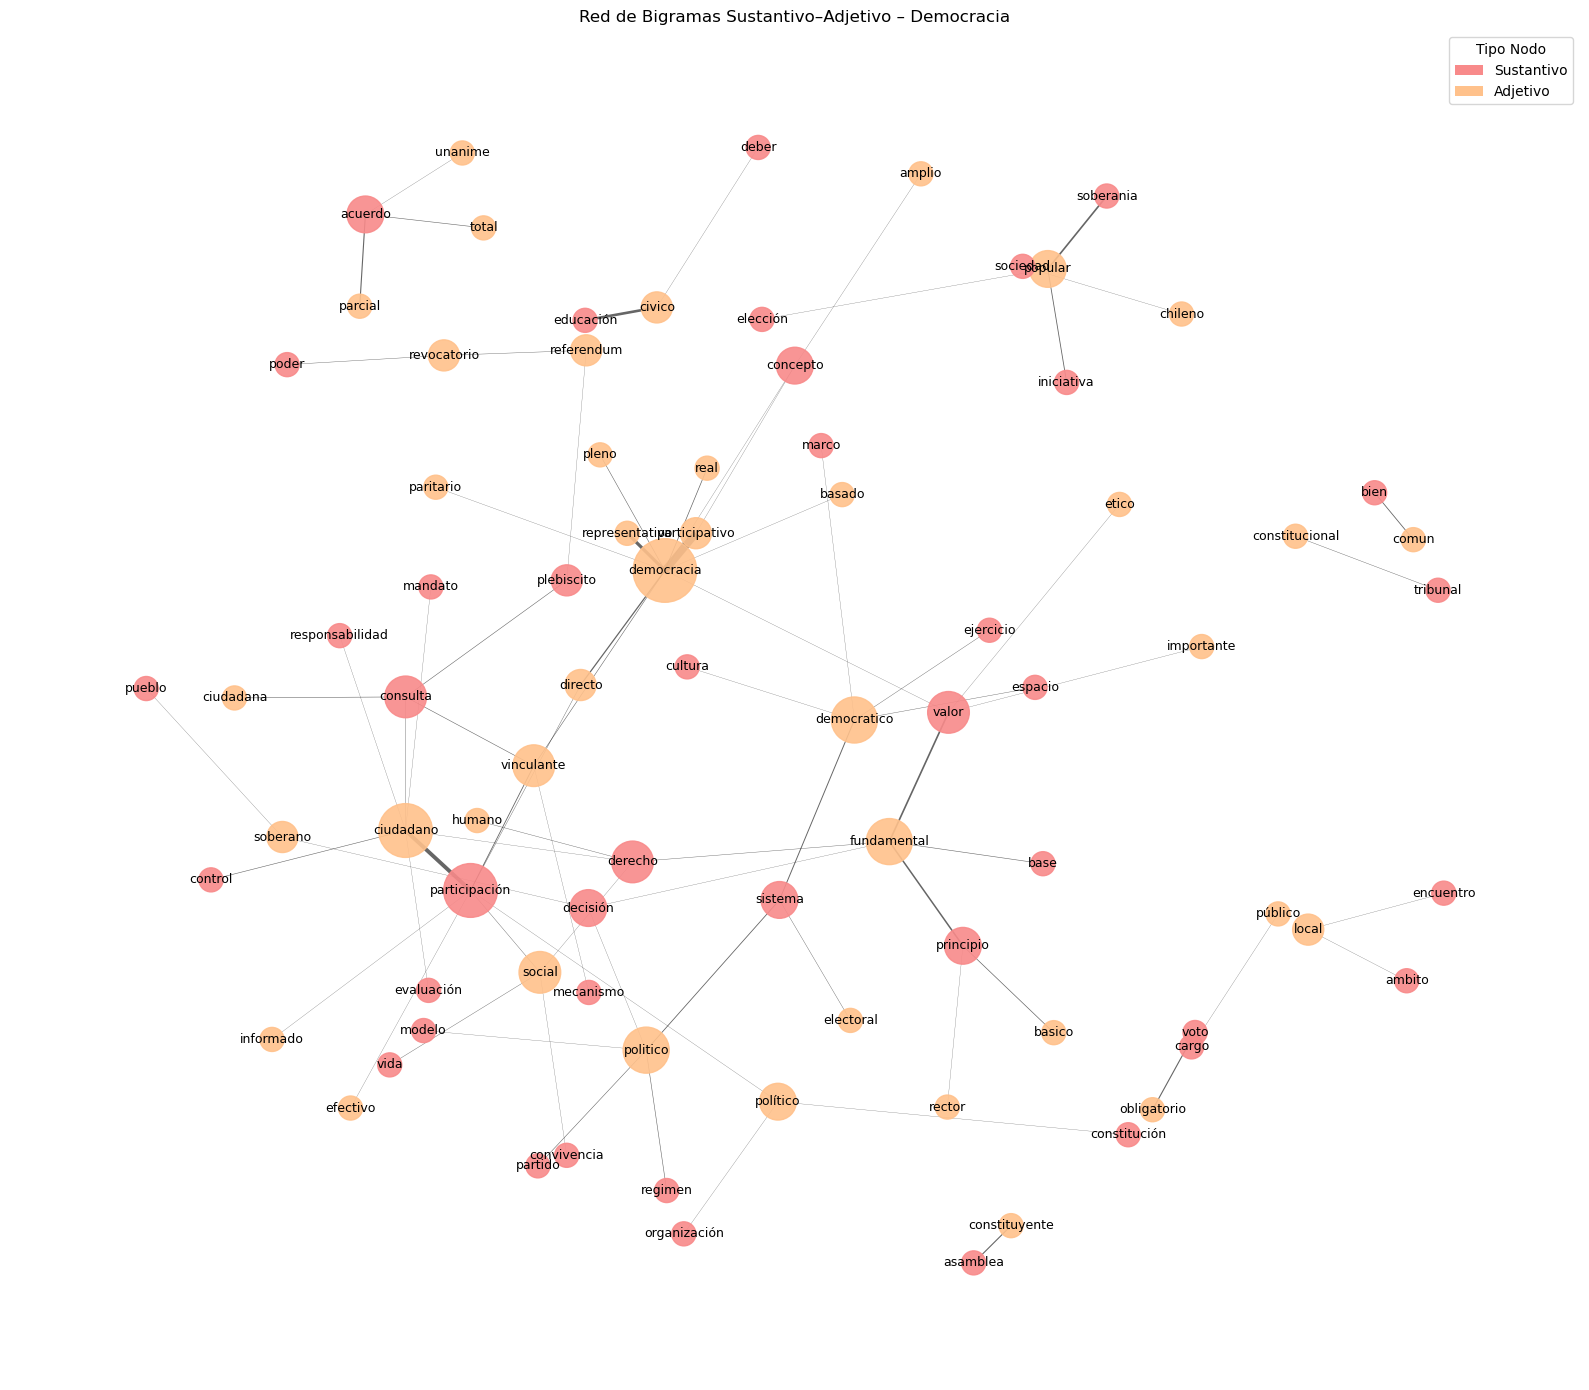

In [39]:
G = nx.Graph()
for big, freq in freq_bigrams.items():
    noun, adj = big.split('_')
    G.add_node(noun, tipo='NOUN')
    G.add_node(adj,  tipo='ADJ')
    G.add_edge(noun, adj, weight=freq)

print('Nodos:', G.number_of_nodes(), '| Aristas:', G.number_of_edges())

# Cálculo de métricas para tamaño y color
degree_dict = dict(G.degree())

# Se escala el tamaño de nodo según grado
node_sizes  = [100 + degree_dict[n]*200 for n in G.nodes()]
color_map = {'NOUN':"#F88A8A", 'ADJ':"#FFC18B"}
node_colors = [color_map[G.nodes[n]['tipo']] for n in G.nodes()]

# Se escala la anchura de arista según peso 
edge_widths = [G[u][v]['weight']*0.1 for u,v in G.edges()]

plt.figure(figsize=(16,14))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=9)

legend_elems = [
    Patch(facecolor=color_map['NOUN'], label='Sustantivo'),
    Patch(facecolor=color_map['ADJ'],  label='Adjetivo')
]
plt.legend(handles=legend_elems, title='Tipo Nodo')

plt.title(f'Red de Bigramas Sustantivo–Adjetivo – {concepto_elegido}')
plt.axis('off')
plt.tight_layout()
plt.savefig('output/figures/red_bigramas.png', dpi=300)
plt.show()

### **10. Interpretación y Ejemplos**
Se seleccionan frases ejemplares del subconjunto para ilustrar el uso de los términos más frecuentes *(sustantivos y bigramas NOUN–ADJ)*.


In [40]:
n_top = 5 # Ejemplos para los top 5 sustantivos
top_nouns = [w for w,_ in all_nouns.most_common(n_top)]

print("========= Ejemplos de Sustantivos ========= ")
for noun in top_nouns:
    print(f"\nSustantivo: '{noun}'")
    ejemplos = subset[subset['texto_norm'].str.contains(
        rf'\b{noun}\b', regex=True)][texto_col].tolist()[:3] # Tres ejemplos donde aparezca el sustantivo
    for ej in ejemplos:
        print(f"- {ej}")

# Ejemplos para los top 5 bigramas NOUN–ADJ
top_bigrams = [b for b,_ in all_bigrams.most_common(n_top)]

print("\n=== Ejemplos de Bigramas Sustantivo–Adjetivo ===")
for big in top_bigrams:
    term = big.replace('_',' ')
    print(f"\nBigrama: '{term}'")
    ejemplos = subset[subset['texto_norm'].str.contains(
        rf'\b{term}\b', regex=True)][texto_col].tolist()[:3]
    for ej in ejemplos:
        print(f"- {ej}")


========= Ejemplos de Sustantivos ========= 

Sustantivo: 'democracia'
- Las condiciones actuales no constituyen democracia. No obstante debe ser un valor fundamental en la nueva Constitucion
- debemos pasar de una democracia representativa a una participativa
- Se garantice una democracia vinculante que se apliquen topes a la acumulación de riquezas

Sustantivo: 'participación'

Sustantivo: 'valor'
- Las condiciones actuales no constituyen democracia. No obstante debe ser un valor fundamental en la nueva Constitucion
- Este concepto no es considerado por el grupo como un valor o principio sino una forma de régimen político
- sin este valor no podría ser un estado

Sustantivo: 'pueblo'
- Participación del pueblo en todas las decisiones
- La decisión soberana debe ser del pueblo. Posibilidad de elegir a nuestros representantes.
- Que se define como el poder del pueblo. Donde el gobierno del pueblo por y para el pueblo.
Entonces: para nosotros según esto, la democracia no se aplica como 